<a href="https://colab.research.google.com/github/varunsaiAlaparthi/reinforcment_learning/blob/main/double_Deep_q_chrome_dino.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn

import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import gym
from collections import namedtuple
import random
import matplotlib.pyplot as plt

In [ ]:
!pip install selenium
!apt-get update # to update ubuntu to correctly run apt install
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin


In [ ]:
pip install gym-chrome-dino

In [ ]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

**Abstract**

I wrote this double deep q algoritham to train an RL agent to play the chrome dino game. I was initially using the normal DQN algorithm , but the training was very unstable , SO later I switched to Double Deep q networks. The entire pipeline is I have an image encoder which is a basic cnn, where I bundle 4 frames 1 current and 3 previous and encode it using CNN , after encoding the vector will be fed into the q network as a state , and the network assigns q values, for each state action pairs. The algorithms uses replay buffer to store the experience/episodes , state, action , reward and next state values. I have then random sampled experiences and trained the network again so that the agent doesn't forget past experiences, there's also priority replay buffers where episodes which have high q values - reward differences will be sampled first. As I am using double deep q networks, I am using 2 networks policy and a target network.

I am also using epsilon - greedy strategy which is mostly common for RL algorithms which pushed the agents to explore more increasing the randomness in taking actions, once it's trained on all possibilties , we make the model exploit more with occasional exploration.

Training :

For each experience in the batch, the target Q-value is computed using the Double Q-Learning approach:

The policy network is used to determine the action taking the argmax Q-value for the next state.

The target network then evaluates the Q-value for that action to compute the target.

The Q-Network is updated by minimizing the difference between the predicted Q-values and the computed target Q-values.

The target network updates periodically using soft update, this is the main advantage which keeps the target stable.

This is the demo that i got:
https://www.youtube.com/watch?v=3nfH1JJUL0g

In [ ]:
#Install the chrome dino packages for running the gym simulator
import gym_chrome_dino
from gym_chrome_dino.utils.wrappers import make_dino
import cv2

In [ ]:
num_epochs=4
alpha=1e-4
batch_size=512

In [ ]:
#Creating a named tuple for storing the experience

Experience = namedtuple('Experience',('state','action','next_state','reward','done'))

In [ ]:

#This is the class that I am using for replaymemory, which has push which is called after every episode, and sample for creating mini
#batches to train later on, This is fine as the q learning algorithms are off policy. can provide is just for a flag to check if there
#are enough experiences.

class replaymemory():
  def __init__(self,capacity):
    self.capacity=capacity
    self.memory=[]
    self.push_count=0

  def push(self,experience):
    if(self.push_count>self.capacity):
      self.memory[self.push_count%self.capacity]=experience
    else:
      self.memory.append(experience)
    self.push_count+=1


  def sample(self,batch_size):
    e=random.sample(self.memory,batch_size)
    #print(type(e1.state))
    states=torch.tensor([e1.state for e1 in e]).to(device)
    actions=torch.tensor([e1.action for e1 in e]).to(device)
    next=torch.tensor([e1.next_state for e1 in e]).to(device)
    rewards = torch.tensor(([e1.reward for e1 in e])).to(device)
    dones = torch.tensor([e1.done for e1 in e])

    #states=states.view(64,1,80,160)
    return states.float(),actions,next,rewards,dones

  def can_provide(self,batch_size):
    return len(self.memory)>=batch_size

In [ ]:
#I am just using this to create a 4 framed array, so that I can concatenate the latest 4 batched frames always

class cstate():
  def __init__(self,size):
    self.size=size
    self.states=[]
    self.push_count=0
  def push(self,state):
    if self.push_count<self.size:
      self.states.append(state)
      self.push_count=self.push_count+1
    else:
      self.states.pop(0)
      self.states.append(state)





In [ ]:
#This is the class for epsilon strategy , where with greedy which is used for exploitation , I am just using argmax to get the action
# with the highest q value, where as for get_action depends on the epsilon value, here I am decaying it exponentially, so
# in the inital phases it favours more of exploration and as episodes go on it favours more of exploitation.

class eps_strat():
  def __init__(self,num_actions,start,decay,end,device):
    self.cur_step=0
    self.num=num_actions
    self.device=device
    self.start=start
    self.decay=decay
    self.end=end
  def get_action(self,policy,state,step):
    self.cur_step=step
    ep=self.end+(self.start-self.end) * np.exp(-1*self.cur_step*self.decay)
    #self.cur_step=self.cur_step+1
    #print(ep,self.cur_step)
    if ep>random.random():
      #print("NO")
      action=random.randrange(self.num)
      return action
    else:
      policy.eval()
      with torch.no_grad():
        #print("yes")
        return torch.argmax(policy.forward(state)).item()
  def get_value(self,step):
    self.cur_step=step
    ep=self.end+(self.start-self.end) * np.exp(-1*self.cur_step*self.decay)
    return ep
  def greedy(self,policy,state):
    policy.eval()
    with torch.no_grad():
      return torch.argmax(policy.forward(state)).item()



In [ ]:
#This is my convolutional network architecture

class convnet(nn.Module):
  def __init__(self):
    super(convnet,self).__init__()
    self.conv1= nn.Conv2d(4,32,8)
    self.conv2 = nn.Conv2d(32,64,4)
    self.conv3=nn.Conv2d(64,64,3)
    self.fc1=nn.Linear(64*68*68,512)
    self.fc2=nn.Linear(512,64)
    self.fc3=nn.Linear(64,2)

  def forward(self,x):
    out=F.relu(self.conv1(x))
    out=F.relu(self.conv2(out))
    out=F.relu(self.conv3(out))
    out = out.view(-1,64*68*68)
    out=F.relu(self.fc1(out))
    out=F.relu(self.fc2(out))
    out=self.fc3(out)
    return out

In [ ]:
class lin(nn.Module):
  def __init__(self):
    super(lin,self).__init__()
    self.fc1=nn.Linear(2,128)
    self.fc2=nn.Linear(128,64)
    self.fc3=nn.Linear(64,2)
  def forward(self,x):
    out=F.relu(self.fc1(x))
    out=F.relu(self.fc2(out))
    out=self.fc3(out)
    return out

In [ ]:
# This is the duelling netowork that I wanted to try out, as there are claims that duelling networks works better than double dqn.
class duelling(nn.Module):
  def __init__(self,num_actions):
    super(duelling,self).__init__()
    self.a = num_actions
    self.conv1 = nn.Conv2d(4,32,8)
    self.conv2 =nn.Conv2d(32,64,4)
    self.conv3 = nn.Conv2d(64,64,3)
    self.fc1_value = nn.Linear(64*68*68,512)
    self.fc2_value = nn.Linear(512,64)
    self.fc3_value = nn.Linear(64,1)
    self.fc1_adv = nn.Linear(64*68*68,512)
    self.fc2_adv = nn.Linear(512,64)
    self.fc3_adv = nn.Linear(64,self.x)
  def forward(self,x):
    out=F.relu(self.conv1(x))
    out = F.relu(self.conv2(out))
    out = F.relu(self.conv3(out))
    out = out.view(-1,64*68*68)
    state_value = F.relu(self.fc1_value(out))
    state_value = F.relu(self.fc2_value(state_value))
    state_value = self.fc3_value(state_value)
    advantage = F.relu(self.fc1_adv(out))
    advantage = F.relu(self.fc2_adv(advantage))
    advantage = self.fc3_adv(advantage)

    return state_value+advantage-torch.mean(advantage)



In [ ]:
#This is the function that I am using to update the target network , soft update

def soft_update(local,target,t):
  for target_param,local_param in zip(target.parameters(),local.parameters()):
    target_param.data.copy_(t*local_param.data+(1-t)*target_param.data)

In [ ]:
#Initialising the target net and policy network and making them start with the same weights for stability reasons

target_net = convnet().to(device)
policy=convnet().to(device)
soft_update(policy,target_net,1)





In [ ]:
num_episodes=1000000
from PIL import Image

In [ ]:
#converting the image frames by doing pre processing.

def convert1(observation):
  cv2_imshow(np.array(observation))
  ob=torch.tensor(observation)
  ob=ob.view(4,80,160)
  ob=ob.numpy()

  f_ob=[]
  for i in range(4):
    l=ob[i]
    cv2_imshow(l)
    print("wtf")
    im = Image.fromarray(l)

    f_ob.append(np.asarray(im.resize((80,80))))

  f_ob=np.array(f_ob)

  ob=torch.tensor([f_ob]).to(torch.float)
  ob=ob.view(-1,4,80,80)
  return ob

In [ ]:
#initialising memory replay with 10000 capacity
mem=replaymemory(10000)

In [ ]:
from PIL import Image
def convert(observation):
  ob=np.array(observation,dtype="float32")
  #print(ob.shape)

  ob=cv2.cvtColor(ob,cv2.COLOR_BGR2GRAY)
  im = Image.fromarray(ob)
  ob = np.asarray(im.resize((80,80)))


  return ob

In [ ]:
#Creating and intialising the gym environment and pushing the first 4 frames into the stack and initialising other parameters required.
env = gym.make('ChromeDino-v0')
from google.colab.patches import cv2_imshow

ob=env.reset()
done_1=False
ob=convert(ob)

print(ob.shape)
stack=cstate(4)

stack.push(ob)
stack.push(ob)
stack.push(ob)
stack.push(ob)

a2=torch.tensor([stack.states])

a= nn.Conv2d(4,32,8)
b = nn.Conv2d(32,64,4)
c=nn.Conv2d(64,64,3)
out=a(a2)
out=b(torch.tensor(out))
out=c(torch.tensor(out))
print(out.shape)
#env=env.unwrapped
state=env.reset()
reward_sum=0
gamma=torch.tensor(0.999)

start=1
end=0.00001
decay=0.1
#decay=0.1

#tau for soft update

tau=0.89

t_decay=eps_strat(2,0.9,0.01,0.001,device)
print(tau)

(80, 80)
torch.Size([1, 64, 68, 68])
0.89


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [ ]:
FILE='/content/drive/MyDrive/chrome_dino/target_net_dino_3.pth'
File='/content/drive/MyDrive/chrome_dino/model_dino_3.pth'
from IPython.display import clear_output
#model.load_state_dict(torch.load(file_path))
target_net.load_state_dict(torch.load(FILE))
policy.load_state_dict(torch.load(File))

<All keys matched successfully>

0 27


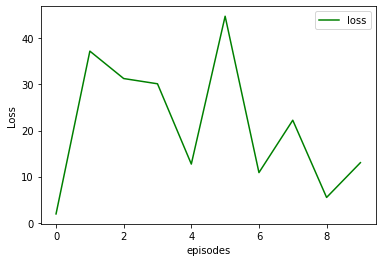

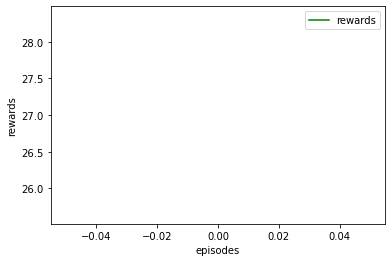

Weights saved
1 3115
2 319


KeyboardInterrupt: ignored

In [ ]:
import cv2
height=720
width=1200
fps=10
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Setting up video encoding format

FILE='/content/drive/MyDrive/chrome_dino/target_net_dino_5.pth'  # File path for saving target network
File='/content/drive/MyDrive/chrome_dino/model_dino_5.pth'       # File path for saving policy network
step=0
step_1=0
eps=0
lo=[]  # list to store loss values for plotting
re=[]  # list to store rewards for plotting
video=[]
video_ep=[]  # List to store video frames for the current episode
max_rew=0  # keeping track track of the max reward

for eps in range(num_episodes):  # Training loop over a specified number of episodes

    reward_sum=0  # initi total reward for the current episode
    state=env.reset()  # Reseteting the environment
    state=convert(state)

    done_1=False  # flag to check if the current episode is done
    video_ep=[]
    while not done_1:  # Loop until the episode ends
        step=step+1
        ep=eps_strat(2, start, decay, end, device)  # Create epsilon-greedy strategy for exploration-exploitation

        # Get the current state stack and reshape it for the network
        a2=torch.tensor(stack.states)
        a2=a2.view(1,4,80,80)
        action= ep.get_action(policy, a2.float().to(device), step)  # Select an action based on epsilon-greedy policy

        next_state, reward, done_1, info = env.step(action)  # Take the action in the environment
        video_ep.append(next_state)  # Add frame to current episode video frames

        next_state=convert(next_state)
        stack.push(next_state)  # Push the new state onto the state stack
        a3=torch.tensor(stack.states)
        a3=a3.view(1,4,80,80)

        reward = 1

        if done_1:
            reward = -10  # Setting reward to -10 for game over, as the agent died

        # storing the experience in the replay memory
        e1 = Experience(a2.numpy(), action, a3.numpy(), reward, done_1)
        mem.push(e1)

        reward_sum += reward  # accumulate the rewards for this episode
        state = next_state  #update to nest state

    if max_rew < reward_sum:
        max_rew = reward_sum
        video = video_ep.copy()

    re.append(reward_sum)  # Track rewards for plotting
    print(eps, reward_sum)

    if mem.can_provide(64):  # If enough experiences are in the replay buffer, start training
        epochs = 10
        for i in range(epochs):
            states_1, actions, next_states, rewards, done = mem.sample(64)  # Sample a mini-batch of experiences

            # Reshape the sampled states for the network
            states_1 = states_1.view(64, 4, 80, 80)
            next_states = next_states.view(64, 4, 80, 80)

            # Calculate the expected Q values using the policy network
            ex = policy.forward(next_states.float()).detach().cpu().numpy().tolist()
            target_q = target_net.forward(next_states.float()).detach().cpu().numpy()
            j = [t.index(max(t)) for t in ex]  # Get the action indices with the highest Q-values

            # Select the target Q-values corresponding to the best actions
            target_q = torch.tensor([target_q[i][j[i]] for i in range(len(j))]).to(device).detach()

            done = done.int().to(device)
            q = (rewards + gamma * (target_q * (1 - done))).detach()  # Calculate the target Q-values
            q = q.unsqueeze(1)
            l = torch.tensor([actions[i] for i in range(64)]).to(device)
            l = l.unsqueeze(1)

            # Calculate the loss between the predicted Q-values and the target Q-values
            exp_q = policy.forward(states_1.float()).gather(-1, l)
            loss = nn.MSELoss()
            tr = loss(exp_q, q)
            lo.append(tr)  # Track loss for plotting

            # Perform a gradient descent step
            optimizer = torch.optim.Adam(policy.parameters(), lr=alpha)
            optimizer.zero_grad()
            tr.backward()
            optimizer.step()

    if eps % 100 == 0:  # Every 100 episodes, update the target network and plot training metrics
        soft_update(policy, target_net, 1)
        episodes = range(len(lo))
        epi = range(len(re))
        plt.plot(episodes, lo, 'g', label='loss')
        plt.xlabel('episodes')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
        plt.plot(epi, re, 'g', label='rewards')
        plt.xlabel('episodes')
        plt.ylabel('rewards')
        plt.legend()
        plt.show()

    if eps % 50 == 0:  # Save the model weights and best video frames every 50 episodes
        torch.save(target_net.state_dict(), FILE)
        torch.save(policy.state_dict(), File)
        print("Weights saved")
        np.save('dino', np.array(video))


In [ ]:
for i in video:
  cv2_imshow(i)
  time.sleep(0.07)
  clear_output()


In [ ]:
for ep in range(num_episodes): yo yo for you
  reward_sum=0
  htyuukhj=8
  state=env.reset()
  done_1=False
  while not done_1:

    ep=eps_strat(2,start,decay,end,device)
    action= ep.get_action(policy,state)
    next_state,reward,done_1,info=env.step(action)


    if done_1==True:
      reward=-10
    else:
      reward=1
    e1=Experience(state,action,next_state,reward,done_1)
    #print(type(e1.state))
    mem.push(e1)
    reward_sum+=reward
    state=next_state
    #print(reward)
  If reward_sum>300
  print(ep,reward_sum)

  if(mem.can_provide(512)):
    states,actions,next_states,rewards,done=mem.sample(512)
    target_q=target_net.forward(next_states.float()).detach()
    target_q=torch.tensor([max(t) for t in target_q]).to(device)

    done=done.int().to(device)

    q=rewards+gamma*(target_q*(1-done))
    #print(gamma*(target_q*(1-done)))
    exp_q=target_net.forward(states.float())
    exp_q=torch.tensor([exp_q[i][actions[i]] for i in range(10)],requires_grad=True).to(device)
    #loss function
    loss=nn.MSELoss()
    tr=loss(q,exp_q)
    tr.backward()
    # optimizer
    optimizer= torch.optim.SGD(policy.parameters(),lr=alpha)
    optimizer.step()
    optimizer.zero_grad()

SyntaxError: ignored

In [ ]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1

In [ ]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1

In [ ]:
from IPython import display as ipythondisplay

In [ ]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()